In [3]:
import numpy as np
import pandas as pd

import torch
from torch import nn


from scipy.io import wavfile

from torchvision import models

from tqdm import tqdm

import os
import shutil
import tarfile

import librosa
import random

import pickle

import time

import IPython.display as ipd

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import seaborn as sns

%matplotlib inline

In [2]:
def get_paths_to_wavs(path_to_dataset):
    file_paths_list = []

    for root, dirs, files in os.walk(path_to_dataset):
        if len(files) != 0:
            file_paths_list += [os.path.join(root, f) for f in files if f.endswith('.wav')]

    return file_paths_list

def get_paths_to_npys(path_to_dataset):
    # get a list with all absolute paths to each file
    file_paths_list = []

    for root, dirs, files in os.walk(path_to_dataset):
        if len(files) != 0:
            file_paths_list += [os.path.join(root, f) for f in files if f.endswith('.npy')]
            #file_paths_list += [os.path.join(root, f) for f in files if os.path.isdir(os.path.join(root, f))]

    return file_paths_list

class numpy_ravdess_dataset(torch.utils.data.Dataset):
    '''
    Due to librosa reads wav-files very slow it is more preferable to read the
    numpy representations of the original wavs
    '''

    emotions_dict = {
        0: 'neutral',
        1: 'calm',
        2: 'happy',
        3: 'sad',
        4: 'angry',
        5: 'fearful',
        6: 'disgust',
        7: 'surprised'
        }

    def __init__(self, paths_to_wavs_list, spectrogram_shape, mode):
        super(numpy_ravdess_dataset, self).__init__()

        self.paths_to_wavs_list = paths_to_wavs_list

        self.mfcc_rows = spectrogram_shape[0]
        self.mfcc_cols = spectrogram_shape[1]
        self.mode = mode

    def __len__(self):
        return len(self.paths_to_wavs_list)
    '''
    def read_audio(self, path_to_wav):
        return np.load(path_to_wav, allow_pickle=True)
    '''
    def read_audio(self, path_to_wav):
        sr, wav = wavfile.read(path_to_wav)
        wav = (wav / 32768).astype(np.float32)
        return wav, sr

    def get_class_label(self, path_to_file):
        # Parse the filename, which has the following pattern:
        # modality-vocal_channel-emotion-intensity-statement-repetition-actor.wav
        # e.g., '02-01-06-01-02-01-12.wav'
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        class_label = int(file_name.split('-')[2]) - 1 # 2 is a number of emotion code
        return class_label
        

    def __getitem__(self, idx):
        path_to_wav = self.paths_to_wavs_list[idx]
        # debug
        #print(path_to_wav)

        # read the wav file
        wav, sr = self.read_audio(path_to_wav)       

        # augmentation
        
        if self.mode == 'TRAIN':
            # add noise
            if np.random.randint(0, 2) == 1:
                sigma = np.random.uniform(0.0009, 0.0051)
                noise = sigma * np.random.randn(len(wav))
                wav += noise
            # stretch wav
            if np.random.randint(0, 2) == 1:
                factor = np.random.uniform(0.5, 1.2)
                wav = librosa.effects.time_stretch(wav, 2)
            # change pitch
            if np.random.randint(0, 2) == 1:
                factor = np.random.uniform(-1.5, 1.1)
                wav = librosa.effects.pitch_shift(wav, sr=sr, n_steps=factor)
    
        # get mfcc coefficients
        #mfccs = librosa.feature.mfcc(wav, sr=sr, n_mfcc=self.mfcc_rows, n_mels=self.mfcc_rows).astype(np.float32)
        '''
        if self.mode == 'TRAIN':
            # augment by choosing n_fft
            n_fft_list = [i for i in range(1024, 2049, 32)]
            idx = np.random.randint(len(n_fft_list))
            n_fft = n_fft_list[idx]
        else:
            n_fft = 2048

        '''
        '''
        n_fft = 2048
        mfccs = librosa.feature.melspectrogram(wav, sr=sr, n_mels=self.mfcc_rows, n_fft=n_fft, hop_length=128).astype(np.float32)

        '''
        mfccs = librosa.core.stft(wav, n_fft=512)#.astype(np.float32)
        mfccs = np.abs(mfccs)**2
        mfccs = np.log(mfccs + 1)
        mfccs = mfccs[:-1]
        
        #mfccs = (mfccs - mfccs.mean())/np.std(mfccs)

        actual_mfcc_cols = mfccs.shape[1]

        # prmitive time-shifting augmentation
        target_real_diff = actual_mfcc_cols - self.mfcc_cols
        if target_real_diff > 0:
            
            if self.mode == 'TRAIN':
                beginning_col = np.random.randint(target_real_diff)
            else:
                beginning_col = actual_mfcc_cols//2 - self.mfcc_cols//2

            mfccs = mfccs[:, beginning_col:beginning_col + self.mfcc_cols]
            #mfccs = mfccs[:, beginning_col:beginning_col + self.mfcc_cols]

        elif target_real_diff < 0:
            zeros = np.zeros((self.mfcc_rows, self.mfcc_cols), dtype=np.float32)
            
            if self.mode == 'TRAIN':
                beginning_col = np.random.randint(self.mfcc_cols-actual_mfcc_cols)
            else:
            
                beginning_col = self.mfcc_cols//2 - actual_mfcc_cols//2
            zeros[..., beginning_col:beginning_col+actual_mfcc_cols] = mfccs
            #zeros[..., beginning_col:beginning_col+actual_mfcc_cols] = mfccs
            mfccs = zeros
            #mfccs = np.pad(mfccs, ((0, 0), (0, np.abs(target_real_diff))), constant_values=(0), mode='constant')

        # make the data compatible to pytorch 1-channel CNNs format
        mfccs = np.expand_dims(mfccs, axis=0)

        # normalize spectrogram
        mfccs = (mfccs - mfccs.mean())/np.std(mfccs)

        # Parse the filename, which has the following pattern:
        # modality-vocal_channel-emotion-intensity-statement-repetition-actor.wav
        # e.g., '02-01-06-01-02-01-12.wav'
        #file_name = os.path.split(path_to_wav)[1]
        #file_name = file_name[:-4]
        #class_label = int(file_name.split('-')[2]) - 1 # 2 is a number of emotion code
        #class_label = np.array(class_label)
        class_label = self.get_class_label(path_to_wav)
        # !!!!!!!!!
        return torch.from_numpy(mfccs), class_label#, path_to_wav

class numpy_crema_dataset(numpy_ravdess_dataset):
    emotions_dict = {
        'ANG': 0,
        'DIS': 1,
        'FEA': 2,
        'SAD': 3,
        'HAP': 4,
        'NEU': 5
    }

    label2str = {
        0: 'ANG',
        1: 'DIS',
        2: 'FEA',
        3: 'SAD',
        4: 'HAP',
        5: 'NEU'
    }
    
    def get_class_label(self, path_to_file):
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        emotion_name = file_name.split('_')[2] # 2 is a number of emotion code
        return self.emotions_dict[emotion_name]

class numpy_iemocap_dataset(numpy_ravdess_dataset):
    '''
    emotions_dict = {
        'exc': 0,
        'sad': 1,
        'fru': 2,
        'hap': 3,
        'neu': 4,
        'sur': 5,
        'ang': 6,
        'fea': 7,
        'dis': 8,
        #'oth': 9
    }
    '''
    emotions_dict = {
        'exc': 0,
        'sad': 1,
        'fru': 2,
        'hap': 3,
        'neu': 4,
        'ang': 5,
    }

    def get_class_label(self, path_to_file):
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        emotion_name = file_name.split('_')[-1] # the last is a position of emotion code
        return self.emotions_dict[emotion_name]

class crema_gender_dataset(numpy_ravdess_dataset):
    emotions_dict = {
        'ANG_Male': 0,
        'DIS_Male': 1,
        'FEA_Male': 2,
        'SAD_Male': 3,
        'HAP_Male': 4,
        'NEU_Male': 5,
        'ANG_Female': 6,
        'DIS_Female': 7,
        'FEA_Female': 8,
        'SAD_Female': 9,
        'HAP_Female': 10,
        'NEU_Female': 11
    }

    label2str = {
        0: 'ANG',
        1: 'DIS',
        2: 'FEA',
        3: 'SAD',
        4: 'HAP',
        5: 'NEU'
    }
    def __init__(self, paths_to_wavs_list, spectrogram_shape, mode, gender_df):
        super().__init__(paths_to_wavs_list, spectrogram_shape, mode)
        self.gender_df = gender_df
    
    def get_class_label(self, path_to_file):
        
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        name_list = file_name.split('_') # 2 is a number of emotion code
        emotion_name = name_list[2]
        actor_id = int(name_list[0])

        gender = self.gender_df[self.gender_df['ActorID'] == actor_id]['Sex'].values[0]

        return self.emotions_dict['{}_{}'.format(emotion_name, gender)]

In [3]:
# define a class that describes an audio CNN
class audio_cnn(nn.Module):
    def __init__(self, rows, cols, num_classes):
        super(audio_cnn, self).__init__()

        self.rows = rows
        self.cols = cols
        self.num_classes = num_classes

        self.conv_extractor = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=(2,2)),

            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2))
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=2048),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=512),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.conv_extractor(x)
        #return x
        #print(x.shape, end='\n\n')
        x = torch.flatten(x, start_dim=1)
        #return x
        #print(x.shape, end='\n\n')
        x = self.fc1(x)
        #return x
        #print(x.shape, end='\n\n')
        x = self.fc2(x)
        #return x
        #print(x.shape, end='\n\n')
        x = self.fc3(x)
        return x

# define a class that describes an audio CNN
class audio_cnn_large_filters(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        
        self.num_classes = num_classes

        self.conv_extractor = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(15,15), stride=2, padding=7),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(11,11), stride=1, padding=5),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2))
            
            
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=512),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.conv_extractor(x)
        #return x
        
        x = torch.flatten(x, start_dim=1)
        #return x
        
        x = self.fc1(x)
        #return x
        x = self.fc2(x)
        
        return x


class MaskConv(nn.Module):
    def __init__(self):
        """
        Adds padding to the output of the module based on the given lengths. This is to ensure that the
        results of the model do not change when batch sizes change during inference.
        Input needs to be in the shape of (BxCxDxT)
        :param seq_module: The sequential module containing the conv stack.
        """
        super(MaskConv, self).__init__()
        #self.seq_module = seq_module
        self.seq_module = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        )

    def forward(self, x):
        """
        :param x: The input of size BxCxDxT
        :param lengths: The actual length of each sequence in the batch
        :return: Masked output from the module
        """
        lengths = torch.IntTensor([x.size(-1)])
        for module in self.seq_module:
            x = module(x)
            mask = torch.BoolTensor(x.size()).fill_(0)
            if x.is_cuda:
                # !!!!
                device = x.device
                mask = mask.to(device)
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths

class audio_cnn_with_extractor(nn.Module):
    def __init__(self, num_classes, path_to_pretrained):
        super().__init__()
        self.num_classes = num_classes
        self.extractor = MaskConv()

        self.extractor.load_state_dict(torch.load(path_to_pretrained))
        for p in self.extractor.parameters():
            p.requires_grad = False

        self.learning_conv = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2))
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16384, out_features=4096),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=1024),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=256),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=num_classes)
        )
        
    def forward(self, x):
        h, _ = self.extractor(x)
        h = self.learning_conv(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.fc2(h)
        h = self.fc3(h)
        return h



In [105]:
net = audio_cnn_with_extractor(num_classes=6, path_to_pretrained='conv_extractor_an4.pth')
net(torch.randn((1, 1, 256, 256))).shape
#summary(net, input_size=(1, 256, 256), batch_size=64, device='cpu')

torch.Size([1, 6])

In [92]:
net = MaskConv()
net.load_state_dict(torch.load('conv_extractor_an4.pth'))
out, lengths = net(torch.randn((1, 1, 256, 256)))
out.shape
#summary(net, input_size=(1, 256, 256), batch_size=64, device='cpu')

torch.Size([1, 32, 64, 128])

In [76]:
out.shape

torch.Size([1, 32, 64, 128])

In [4]:
def index_dataset(paths_list):
    human_id_dict = {}# OrderedDict()
    phrase_dict = {}#OrderedDict()
    emotion_dict = {}#OrderedDict()
    
    for path in paths_list:
        file_name = os.path.split(path)[1]
        file_name = file_name[:-4]
        name_list = file_name.split('_') # 2 is a number of emotion code
        human_id = name_list[0]
        phrase_id = name_list[1]
        emotion_name = name_list[2]
        
        try:
            human_id_dict[human_id] += 1
        except KeyError:
            human_id_dict[human_id] = 1

        try:
            phrase_dict[phrase_id] += 1
        except KeyError:
            phrase_dict[phrase_id] = 1

        try:
            emotion_dict[emotion_name] += 1
        except KeyError:
            emotion_dict[emotion_name] = 1

    for key in emotion_dict:
        emotion_dict[key] /= len(paths_list)

    for key in phrase_dict:
        phrase_dict[key] /= len(paths_list)

    for key in human_id_dict:
        human_id_dict[key] /= len(paths_list)

    return human_id_dict, phrase_dict, emotion_dict

def validate(model, criterion, testloader, device):

    dataset_size = len(testloader.dataset)  
        
    correct = 0
    total = 0

    model.eval()

    epoch_loss = 0.0
    
    for i, (data, target) in enumerate(testloader):
        t0 = time.time()
        data = data.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            # run forward step
            predicted = model(data)

            loss = criterion(predicted, target)

            epoch_loss += loss.item() * data.size(0)

        _, pred_labels = torch.max(predicted.data, 1)

        total += target.size(0)
        correct += (pred_labels == target).sum().item()


    return epoch_loss/dataset_size, correct/total


def train_num_epochs(model, trainloader, testloader, device, criterion, optimizer, starting_epoch, ending_epoch, basic_name, path_to_weights):
    '''
    model - neural network
    trainloader - pytorch dataloader for training set
    testloader - pytorch dataloader for test set
    device - cpu / cuda
    criterion - loss function (nn.CrossEntropyLoss())
    optimizer - (Adam)
    starting_epoch - 
    ending_epoch - 
    '''
    dataset_size = len(trainloader.dataset)  

    correct = 0
    total = 0

    best_acc = 0.0

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    # iterate over epochs
    for epoch_num in range(starting_epoch, ending_epoch):
        print('Epoch #%d' % (epoch_num))

        # iterate over batches
        epoch_loss = 0.0

        model.train()

        t0 = time.time()
        for i, (data, target) in enumerate(trainloader):
            
            data = data.to(device)
            target = target.to(device)

            # zero all the gradient tensors
            optimizer.zero_grad()
            # run forward step
            predicted = model(data)

            # compute loss
            loss = criterion(predicted, target)

            # compute gradient tensors
            loss.backward()

            # update parameters
            optimizer.step()

            # compute the loss value
            epoch_loss += loss.item() * data.size(0)
            
            total += target.size(0)
            _, pred_labels = torch.max(predicted.data, 1)

            correct += (pred_labels == target).sum().item()
        
        t = time.time() - t0
            
        
        epoch_loss /=  dataset_size
        train_acc = correct/total
        print('# Time passed: %.0f s' % (t))
        print('# Epoch loss = %.4f' % (epoch_loss))
        print('# Train acc = {}'.format(train_acc))
        print('# Validation process on validation set')
        val_loss, val_acc = validate(model, criterion, testloader, device)
        print('# Validation loss = {}'.format(val_loss))
        print('# Validation acc = {}'.format(val_acc))

        #print(val_acc > best_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            model_name = basic_name + '_ep-{}_loss-{:.3}_acc-{:.3}.pth'.format(epoch_num, val_loss, val_acc)
            path_to_saving_model = os.path.join(path_to_weights, model_name)
            torch.save(mfcc_emotion_cnn.state_dict(), path_to_saving_model)
            print('model %s have been saved' % (path_to_saving_model))

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(val_loss)
            
    return model, train_acc_list, val_acc_list, train_loss_list, val_loss_list

In [5]:

# CREMA-D
target_path = '/media/mikhail/files/datasets/emotion_recognition/CREMA-D/AudioWAV'
# IEMOCAP
#target_path = '/media/mikhail/files/datasets/emotion_recognition/IEMOCAP/IEMOCAP_full_release/audios'
 
npys_list = get_paths_to_wavs(target_path)

# shuffle the dataset to for the learning process stability
random.seed(10)
random.shuffle(npys_list)

dataset_size = len(npys_list)
batch_size = 32

train_size = int(0.8 * dataset_size)

print(dataset_size)

train_dataset = numpy_crema_dataset(npys_list[:train_size], (256, 256), mode='TRAIN')
#train_dataset = numpy_iemocap_dataset(npys_list[:train_size], (256, 256), mode='TRAIN')

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# set up test dataset and test dataloader
test_dataset = numpy_crema_dataset(npys_list[train_size:], (256, 256), mode='TEST')
#test_dataset = numpy_iemocap_dataset(npys_list[train_size:], (256, 256), mode='TEST')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

7442


In [6]:
# set-up devices
cuda = torch.device('cuda:1')
cpu = torch.device('cpu')

#model = audio_cnn_large_filters(num_classes=len(train_dataset.emotions_dict))
model = audio_cnn_with_extractor(num_classes=6, path_to_pretrained='conv_extractor_an4.pth')
#summary(model, input_size=(1, 256, 256), batch_size=batch_size, device='cpu')

device = cuda

model.to(device)

criterion = nn.CrossEntropyLoss()
# define an optimization algorithm and bind it with the NN parameters
optimizer = torch.optim.Adam(params=model.parameters())

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

starting_epoch = 0
ending_epoch = 1000
epoch_step = 1

basic_name = '{}_log_pow_spec_cnn_pretrained'.format('CREMA')



path_to_weights = basic_name
path_to_pkl = basic_name

if not os.path.isdir(path_to_weights):
    os.mkdir(path_to_weights)
if not os.path.isdir(path_to_pkl):
    os.mkdir(path_to_pkl)

In [7]:
start_epoch = 0
epochs = 500
epoch_step = 1

print('Start learning')


best_acc = 0.0

train_dataset_size = len(train_dataloader.dataset)  
test_dataset_size = len(test_dataloader.dataset)  


if os.path.exists(os.path.join(path_to_pkl, basic_name + '_train_loss.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_train_loss.pkl'), "rb") as f:
        train_loss_list = pickle.load(f)
else:
  train_loss_list = []

if os.path.exists(os.path.join(path_to_pkl, basic_name + '_train_acc.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_train_acc.pkl'), "rb") as f:
        train_acc_list = pickle.load(f)
else:
  train_acc_list = []

if os.path.exists(os.path.join(path_to_pkl, basic_name + '_val_loss.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_val_loss.pkl'), "rb") as f:
        val_loss_list = pickle.load(f)
else:
  val_loss_list = []

if os.path.exists(os.path.join(path_to_pkl, basic_name + '_val_acc.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_val_acc.pkl'), "rb") as f:
        val_acc_list = pickle.load(f)
else:
    val_acc_list = []


t = 0.0

for epoch_idx in range(start_epoch, epochs, epoch_step):

    print('#############################################')
    print('#\tStart training process')
    print('#############################################\n\n')

    # iterate over epochs
    for epoch in range(epoch_step):
        print('Epoch #{}'.format(epoch_idx + epoch))
        t0 = time.time()
        model.train()
        # define losses and correct valuse number for each epoch
        epoch_train_loss = 0.0
        correct = 0
        total = 0
        
        # iterate over batches
        for data, labels in train_dataloader:
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * data.size(0)
            total += labels.size(0)
            _, pred_labels = torch.max(pred.data, 1)

            correct += (pred_labels == labels).sum().item()

        t1 = time.time()

        print('Epoch time = {:.3f} s'.format(t1 - t0))

        train_loss = epoch_train_loss / train_dataset_size
        train_acc = correct/total

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        print('Loss = %f\tTraining acc = %f' % (train_loss, train_acc))
        print('----------------------------------------')
        
        print('#############################################')
        print('#\tStart validation on %d epoch' % (epoch_idx + epoch))
        print('#############################################')
        
        model.eval()
        with torch.no_grad():
            true_values = 0.0
            epoch_test_loss = 0.0
            correct = 0
            total = 0
            for data, labels in test_dataloader:
                data = data.to(device)
                labels = labels.to(device)
                # run the model
                pred = model(data)
                loss = criterion(pred, labels)
                epoch_test_loss += loss.item() * data.size(0)
                total += labels.size(0)
                _, pred_labels = torch.max(pred.data, 1)
                correct += (pred_labels == labels).sum().item()
        val_acc = correct/total
        val_loss = epoch_test_loss / test_dataset_size
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        scheduler.step()
                
        print('\tLoss = {:.4f}\tValidation acc = {:.3f}'.format(val_loss, val_acc))
        print('---------------------------------------------')
      
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #save current model to resume training
        #после каждой эпохи сохраняем веса для того, чтобы потом продолжить обучение именно с последней эпохи
        #а не с эпохи с лучшими весами 
        path_to_saving_model = os.path.join(path_to_weights, basic_name + '_current.pth')
        torch.save(model.state_dict(), path_to_saving_model)
            
        if val_acc > best_acc:
            print('#############################################')
            print('#\tBest accuracy has achieved')
            print('#\tSaving weights...')
            print('#############################################\n\n')

            model_name = basic_name + '_ep-{}_loss-{:.3}_acc-{:.3}.pth'.format(epoch_idx + epoch, val_loss, val_acc)
            path_to_saving_model = os.path.join(path_to_weights, model_name)

            torch.save(model.state_dict(), path_to_saving_model)
            print('model {} have been saved'.format(path_to_saving_model))
            best_acc = val_acc

        with open(os.path.join(path_to_pkl, basic_name + '_train_loss.pkl'), 'wb') as f:
            pickle.dump(train_loss_list, f)

        with open(os.path.join(path_to_pkl, basic_name + '_train_acc.pkl'), 'wb') as f:
            pickle.dump(train_acc_list, f)

        with open(os.path.join(path_to_pkl, basic_name + '_val_loss.pkl'), 'wb') as f:
            pickle.dump(val_loss_list, f)

        with open(os.path.join(path_to_pkl, basic_name + '_val_acc.pkl'), 'wb') as f:
            pickle.dump(val_acc_list, f)
    

ime = 80.451 s
Loss = 0.860364	Training acc = 0.684193
----------------------------------------
#############################################
#	Start validation on 180 epoch
#############################################
	Loss = 1.2493	Validation acc = 0.580
---------------------------------------------
#############################################
#	Start training process
#############################################


Epoch #181
Epoch time = 78.778 s
Loss = 0.822999	Training acc = 0.692928
----------------------------------------
#############################################
#	Start validation on 181 epoch
#############################################
	Loss = 1.3400	Validation acc = 0.564
---------------------------------------------
#############################################
#	Start training process
#############################################


Epoch #182
Epoch time = 77.852 s
Loss = 0.814524	Training acc = 0.693768
----------------------------------------
######################

KeyboardInterrupt: 

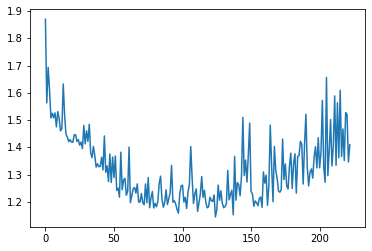

In [8]:
plt.plot(val_loss_list)

In [26]:
emotions_dict = {
        'exc': 0,
        'sad': 1,
        'fru': 2,
        'hap': 3,
        'neu': 4,
        'ang': 5,
    }

for i in tqdm(range(7304)):
    file_name = os.path.split(npys_list[i])[1]
    file_name = file_name[:-4]
    emotion_name = file_name.split('_')[-1] # the last is a position of emotion code
    emotion_class = emotions_dict[emotion_name]

100%|██████████| 7304/7304 [00:00<00:00, 563561.38it/s]


In [27]:
emotion_class

1

In [11]:
# test trained model on another dataset
target_path = '/media/mikhail/files/datasets/emotion_recognition/IEMOCAP/IEMOCAP_full_release/audios'
 
wavs_list = get_paths_to_wavs(target_path)

# shuffle the dataset to for the learning process stability


dataset_size = len(wavs_list)

train_size = int(0.8 * dataset_size)

print(dataset_size)

dataset = numpy_iemocap_dataset(wavs_list, (256, 256), mode='TEST')

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=False, num_workers=4)

7304


In [12]:
class Extractor(audio_cnn):
    def forward(self, x):
        x = self.conv_extractor(x)
        #return x
        #print(x.shape, end='\n\n')
        x = torch.flatten(x, start_dim=1)
        #return x
        #print(x.shape, end='\n\n')
        x = self.fc1(x)
        #return x
        #print(x.shape, end='\n\n')
        x = self.fc2(x)

        return x

device = torch.device('cuda:0')
extractor = Extractor(rows=256, cols=256, num_classes=6)
extractor.load_state_dict(torch.load('/home/mikhail/python_programming/pytorch_projects/emotion_cnn/CREMA_log_spec_emotion_cnn/CREMA_log_spec_emotion_cnn_current.pth'))
# assign arameters to new model
#for p1, p2 in zip(extractor.parameters(), model.parameters()):
 #   p1 = p2

extractor.to(device)

Extractor(
  (conv_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False

In [13]:
features = []
emotions_list = []
with torch.no_grad():
    for data, labels in tqdm(dataloader):
        data = data.to(device)
        # run the model
        pred = extractor(data)
        features.append(pred.cpu().numpy())
        emotions_list.append(labels.item())
        

features = np.array(features)
features = features.reshape((features.shape[0], -1))

100%|██████████| 7304/7304 [00:35<00:00, 208.50it/s]


In [14]:
features.shape

(7304, 512)

In [14]:
tsne_faces = TSNE(n_components=2, verbose=1).fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7304 samples in 0.732s...
[t-SNE] Computed neighbors for 7304 samples in 43.964s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7304
[t-SNE] Computed conditional probabilities for sample 2000 / 7304
[t-SNE] Computed conditional probabilities for sample 3000 / 7304
[t-SNE] Computed conditional probabilities for sample 4000 / 7304
[t-SNE] Computed conditional probabilities for sample 5000 / 7304
[t-SNE] Computed conditional probabilities for sample 6000 / 7304
[t-SNE] Computed conditional probabilities for sample 7000 / 7304
[t-SNE] Computed conditional probabilities for sample 7304 / 7304
[t-SNE] Mean sigma: 1.387636
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.971893
[t-SNE] KL divergence after 1000 iterations: 3.254996


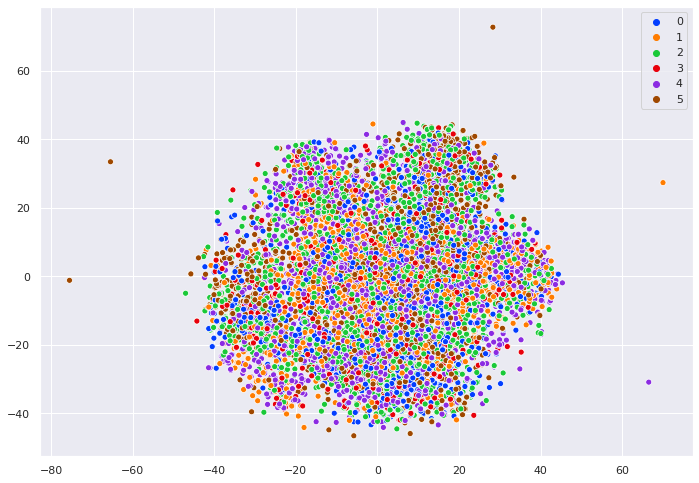

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 6)

sns.scatterplot(tsne_faces[:,0], tsne_faces[:,1], hue=emotions_list, legend='full', palette=palette)

In [25]:
path_to_csv = os.path.join('/media/mikhail/files/datasets/emotion_recognition/CREMA-D', 'VideoDemographics.csv')
demographic_info = pd.read_csv(path_to_csv)
gender_df = demographic_info[['ActorID','Sex']]


# CREMA-D
target_path = '/media/mikhail/files/datasets/emotion_recognition/CREMA-D/AudioWAV'
# IEMOCAP
#target_path = '/media/mikhail/files/datasets/emotion_recognition/IEMOCAP/IEMOCAP_full_release/audios'
 
npys_list = get_paths_to_wavs(target_path)

# shuffle the dataset to for the learning process stability
random.seed(0)
random.shuffle(npys_list)

dataset_size = len(npys_list)

train_size = int(0.8 * dataset_size)

print(dataset_size)

train_dataset = crema_gender_dataset(npys_list[:train_size], (256, 256), 'TRAIN', gender_df)
#train_dataset = numpy_iemocap_dataset(npys_list[:train_size], (256, 256), mode='TRAIN')

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

# set up test dataset and test dataloader
test_dataset = crema_gender_dataset(npys_list[train_size:], (256, 256), 'TEST', gender_df)
#test_dataset = numpy_iemocap_dataset(npys_list[train_size:], (256, 256), mode='TEST')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

7442


In [26]:
# set-up devices
cuda = torch.device('cuda:0')
cpu = torch.device('cpu')

model = audio_cnn(rows=256, cols=256, num_classes=len(train_dataset.emotions_dict))

summary(model, input_size=(1, 256, 256), batch_size=32, device='cpu')

device = cuda

model.to(device)

criterion = nn.CrossEntropyLoss()
# define an optimization algorithm and bind it with the NN parameters
optimizer = torch.optim.Adam(params=model.parameters())

starting_epoch = 0
ending_epoch = 1000
epoch_step = 1

basic_name = '{}_log_pow_spec_emotion_cnn'.format('CREMA_gender')



path_to_weights = basic_name
path_to_pkl = basic_name

if not os.path.isdir(path_to_weights):
    os.mkdir(path_to_weights)
if not os.path.isdir(path_to_pkl):
    os.mkdir(path_to_pkl)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 256, 256]             320
       BatchNorm2d-2         [32, 32, 256, 256]              64
              ReLU-3         [32, 32, 256, 256]               0
            Conv2d-4         [32, 32, 256, 256]           9,248
       BatchNorm2d-5         [32, 32, 256, 256]              64
              ReLU-6         [32, 32, 256, 256]               0
         MaxPool2d-7         [32, 32, 128, 128]               0
            Conv2d-8         [32, 64, 128, 128]          18,496
       BatchNorm2d-9         [32, 64, 128, 128]             128
             ReLU-10         [32, 64, 128, 128]               0
           Conv2d-11         [32, 64, 128, 128]          36,928
      BatchNorm2d-12         [32, 64, 128, 128]             128
             ReLU-13         [32, 64, 128, 128]               0
        MaxPool2d-14           [32, 64,

In [27]:
start_epoch = 0
epochs = 500
epoch_step = 1

print('Start learning')


best_acc = 0.0

train_dataset_size = len(train_dataloader.dataset)  
test_dataset_size = len(test_dataloader.dataset)  


if os.path.exists(os.path.join(path_to_pkl, basic_name + '_train_loss.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_train_loss.pkl'), "rb") as f:
        train_loss_list = pickle.load(f)
else:
  train_loss_list = []

if os.path.exists(os.path.join(path_to_pkl, basic_name + '_train_acc.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_train_acc.pkl'), "rb") as f:
        train_acc_list = pickle.load(f)
else:
  train_acc_list = []

if os.path.exists(os.path.join(path_to_pkl, basic_name + '_val_loss.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_val_loss.pkl'), "rb") as f:
        val_loss_list = pickle.load(f)
else:
  val_loss_list = []

if os.path.exists(os.path.join(path_to_pkl, basic_name + '_val_acc.pkl')):
    # Update existing classifier
    with open(os.path.join(path_to_pkl, basic_name + '_val_acc.pkl'), "rb") as f:
        val_acc_list = pickle.load(f)
else:
    val_acc_list = []


t = 0.0

for epoch_idx in range(start_epoch, epochs, epoch_step):

    print('#############################################')
    print('#\tStart training process')
    print('#############################################\n\n')

    # iterate over epochs
    for epoch in range(epoch_step):
        print('Epoch #{}'.format(epoch_idx + epoch))
        t0 = time.time()
        model.train()
        # define losses and correct valuse number for each epoch
        epoch_train_loss = 0.0
        correct = 0
        total = 0
        
        # iterate over batches
        for data, labels in train_dataloader:
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * data.size(0)
            total += labels.size(0)
            _, pred_labels = torch.max(pred.data, 1)

            correct += (pred_labels == labels).sum().item()

        t1 = time.time()

        print('Epoch time = {:.3f} s'.format(t1 - t0))

        train_loss = epoch_train_loss / train_dataset_size
        train_acc = correct/total

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        print('Loss = %f\tTraining acc = %f' % (train_loss, train_acc))
        print('----------------------------------------')
        
        print('#############################################')
        print('#\tStart validation on %d epoch' % (epoch_idx + epoch))
        print('#############################################')
        
        model.eval()
        with torch.no_grad():
            true_values = 0.0
            epoch_test_loss = 0.0
            correct = 0
            total = 0
            for data, labels in test_dataloader:
                data = data.to(device)
                labels = labels.to(device)
                # run the model
                pred = model(data)
                loss = criterion(pred, labels)
                epoch_test_loss += loss.item() * data.size(0)
                total += labels.size(0)
                _, pred_labels = torch.max(pred.data, 1)
                correct += (pred_labels == labels).sum().item()
        val_acc = correct/total
        val_loss = epoch_test_loss / test_dataset_size
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
                
        print('\tLoss = {:.4f}\tValidation acc = {:.3f}'.format(val_loss, val_acc))
        print('---------------------------------------------')
      
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #save current model to resume training
        #после каждой эпохи сохраняем веса для того, чтобы потом продолжить обучение именно с последней эпохи
        #а не с эпохи с лучшими весами 
        path_to_saving_model = os.path.join(path_to_weights, basic_name + '_current.pth')
        torch.save(model.state_dict(), path_to_saving_model)
            
        if val_acc > best_acc:
            print('#############################################')
            print('#\tBest accuracy has achieved')
            print('#\tSaving weights...')
            print('#############################################\n\n')

            model_name = basic_name + '_ep-{}_loss-{:.3}_acc-{:.3}.pth'.format(epoch_idx + epoch, val_loss, val_acc)
            path_to_saving_model = os.path.join(path_to_weights, model_name)

            torch.save(model.state_dict(), path_to_saving_model)
            print('model {} have been saved'.format(path_to_saving_model))
            best_acc = val_acc

        with open(os.path.join(path_to_pkl, basic_name + '_train_loss.pkl'), 'wb') as f:
            pickle.dump(train_loss_list, f)

        with open(os.path.join(path_to_pkl, basic_name + '_train_acc.pkl'), 'wb') as f:
            pickle.dump(train_acc_list, f)

        with open(os.path.join(path_to_pkl, basic_name + '_val_loss.pkl'), 'wb') as f:
            pickle.dump(val_loss_list, f)

        with open(os.path.join(path_to_pkl, basic_name + '_val_acc.pkl'), 'wb') as f:
            pickle.dump(val_acc_list, f)
    

------------------------
#############################################
#	Start training process
#############################################


Epoch #334
Epoch time = 69.112 s
Loss = 0.404382	Training acc = 0.862254
----------------------------------------
#############################################
#	Start validation on 334 epoch
#############################################
	Loss = 1.5116	Validation acc = 0.632
---------------------------------------------
#############################################
#	Start training process
#############################################


Epoch #335
Epoch time = 60.507 s
Loss = 0.382373	Training acc = 0.872333
----------------------------------------
#############################################
#	Start validation on 335 epoch
#############################################
	Loss = 1.5596	Validation acc = 0.626
---------------------------------------------
#############################################
#	Start training process
######################

KeyboardInterrupt: 

In [8]:

# CREMA-D
target_path = '/media/mikhail/files/datasets/emotion_recognition/CREMA-D/AudioWAV'
# IEMOCAP
#target_path = '/media/mikhail/files/datasets/emotion_recognition/IEMOCAP/IEMOCAP_full_release/audios'
 
npys_list = get_paths_to_wavs(target_path)

# shuffle the dataset to for the learning process stability
random.seed(10)
random.shuffle(npys_list)

dataset_size = len(npys_list)

train_size = int(0.8 * dataset_size)

print(dataset_size)

train_dataset = numpy_crema_dataset(npys_list[:train_size], (256, 256), mode='TRAIN')
#train_dataset = numpy_iemocap_dataset(npys_list[:train_size], (256, 256), mode='TRAIN')

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

# set up test dataset and test dataloader
test_dataset = numpy_crema_dataset(npys_list[train_size:], (256, 256), mode='TEST')
#test_dataset = numpy_iemocap_dataset(npys_list[train_size:], (256, 256), mode='TEST')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

7442


In [5]:
resnet = models.resnet50()
'''
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, )
)
'''
resnet(torch.randn(1, 3, 312, 256))

tensor([[ 3.3982e-01, -2.2661e-02,  1.2276e+00, -1.1380e+00,  6.2206e-01,
          8.1077e-01,  1.5989e-01, -6.0565e-02, -8.6095e-01,  7.1940e-01,
         -2.2608e-01, -2.5870e-01,  1.4039e-02, -5.6315e-02,  1.8091e-01,
         -6.0456e-01,  2.8367e-01, -3.1213e-01,  7.7306e-01, -2.2862e-01,
         -4.7580e-01, -1.0080e+00,  2.3768e-02,  5.4988e-01,  4.0274e-02,
          1.6374e+00,  6.6701e-03,  4.3358e-01, -4.1486e-01,  8.4646e-01,
         -8.0095e-02,  2.2683e-01, -4.0071e-01, -5.6303e-01, -1.0928e+00,
         -4.8067e-01,  6.9756e-02,  1.2114e-01,  1.2353e+00, -8.2025e-01,
          3.1135e-01, -7.3438e-02, -1.7574e+00,  6.2835e-01,  6.1101e-01,
         -7.3580e-02, -2.5302e-02,  1.4978e-01,  6.4473e-01, -3.4148e-01,
          6.1873e-01,  4.8165e-02, -3.1264e-01,  1.1698e-01,  5.4286e-02,
         -1.4127e-02, -1.5045e-01,  1.3961e+00, -6.4602e-01, -1.4503e+00,
          1.2601e+00, -1.9366e-02,  4.3984e-01,  2.8584e-01,  1.9497e-01,
         -6.6975e-02, -1.0303e-01,  1.